# Project Description

**Create a 4D dataset of 3D sub-volumes from a dense EM volume as well as the corresponding GT sag.mask sub-volume dataset.**

The notebook works through the following steps:

* Apply a 3D center crop to the 3D data, segmentations, and masks
* Apply the masks to the data to crop out the background
* Upsample the croped and masked data, as well as the GT segmenations, along x-y plane.
* Store the croped, masked, and upsampled data, as well as the segmentatios, as 3D arrays
* Split the saved 3D volumes in to sub-volumes
* Saver the sub-volumes to two different tiffi files

# Imports

In [1]:
# image manipulation
import cv2
import numpy as np
from PIL import Image
from skimage.transform import resize
from scipy.ndimage import zoom

# data format handling
import tifffile
import h5py

# utility, visualization, and path handling 
from tqdm import tqdm
from glob import glob
from matplotlib import pyplot as plt

# system configurations handling
from yacs.config import CfgNode as CN

# 3D tensor handling
import torch
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

import csv
from shutil import copyfile
import os

# System configurations

In [2]:
_C = CN()

_C.ROOT = "/n/pfister_lab2/Lab/zudilin/data/NucExM/NucExM-Release"
_C.VOLUMES = ["image0.h5","image1.h5","image2.h5","image3.h5","image4.h5","image5.h5"]

_C.DOWNRATE = tuple((1,4,4))
_C.H5KEY = 'main'


def get_cfg_defaults():
  """Get a yacs CfgNode object with default values for my_project."""
  # Return a clone so that the defaults will not be altered
  # This is for the "local variable" use pattern
  return _C.clone()

cfg = get_cfg_defaults()
#cfg.merge_from_file("./configs/base_setup.yaml")
cfg.freeze()

# Data

#### Patch the images

In [4]:
# open the source files for reading
for l in range(0, len(cfg.VOLUMES)):
    with h5py.File(os.path.join(cfg.ROOT, cfg.VOLUMES[l]), 'r') as hdf_dorsal:

        # get the masks
        hdf_dorsal_keys = list(hdf_dorsal.keys()) # prints ['main']
        hdf_dors = hdf_dorsal.get(hdf_dorsal_keys[0])

        images = np.asarray(hdf_dors)
        

        final_image_volume = np.zeros(tuple([s//d for d, s in zip (cfg.DOWNRATE, images.shape)])).astype(np.uint8)

        # preprocess the images: discard outer sclices, mask, zoom
        # iterate over the images and their corresponding names
        for i, img in tqdm(enumerate(images)):            

            # 2. downsample the image and GT mask
            # use bilinear upsampling for the images
            img = resize(img, tuple([s//d for d, s in zip (cfg.DOWNRATE[1:], images.shape[1:])]), order=3, preserve_range=True, anti_aliasing=True)

            final_image_volume[i, :, :] = img

        final_image_volume = (((final_image_volume - np.min(final_image_volume)) / float(np.max(final_image_volume)-np.min(final_image_volume))) * 255).astype(np.uint8)

        
        img_tif_name = os.path.join(os.path.join(cfg.ROOT,"downsampled"), cfg.VOLUMES[l]).split(".")[0]+"_ds_4x.h5"
        with h5py.File(img_tif_name, "w") as h5:
            h5_dataset =  h5.create_dataset("main", data=final_image_volume)



255it [00:34,  7.35it/s]
255it [00:34,  7.35it/s]
255it [00:34,  7.32it/s]
255it [00:33,  7.59it/s]
255it [00:34,  7.43it/s]
255it [00:33,  7.65it/s]


In [5]:
for j in range(0, len(cfg.VOLUMES)):
    with h5py.File(os.path.join(cfg.ROOT, cfg.VOLUMES[j]), 'r') as old, \
         h5py.File(str(os.path.join(os.path.join(cfg.ROOT,"downsampled"), cfg.VOLUMES[j]).split(".")[0]) + "_ds_4x.h5") as new:
        old = np.asarray(old.get(list(old.keys())[0]))
        new = np.asarray(new.get(list(new.keys())[0]))

        assert(old.dtype == "uint8"), "The input image volume should be of type uint8"
        assert(new.dtype == "uint8"), "The input image volume should be of type uint8"

        assert(new.shape == tuple([s//d for d, s in zip (cfg.DOWNRATE, old.shape)]))

        print(f"{cfg.VOLUMES[j]} shape {old.shape}")
        new_name = cfg.VOLUMES[j].split(".")[0] + "_ds_4x.h5"
        print(f"{new_name} shape {new.shape}")
        print("All good!")

/n/home05/lauenburg/.conda/envs/img_toolbox/lib/python3.7/site-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until


image0.h5 shape (255, 2048, 2048)
image0_ds_4x.h5 shape (255, 512, 512)
All good!
image1.h5 shape (255, 2048, 2048)
image1_ds_4x.h5 shape (255, 512, 512)
All good!
image2.h5 shape (255, 2048, 2048)
image2_ds_4x.h5 shape (255, 512, 512)
All good!
image3.h5 shape (255, 2048, 2048)
image3_ds_4x.h5 shape (255, 512, 512)
All good!
image4.h5 shape (255, 2048, 2048)
image4_ds_4x.h5 shape (255, 512, 512)
All good!
image5.h5 shape (255, 2048, 2048)
image5_ds_4x.h5 shape (255, 512, 512)
All good!


/n/home05/lauenburg/.conda/envs/img_toolbox/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


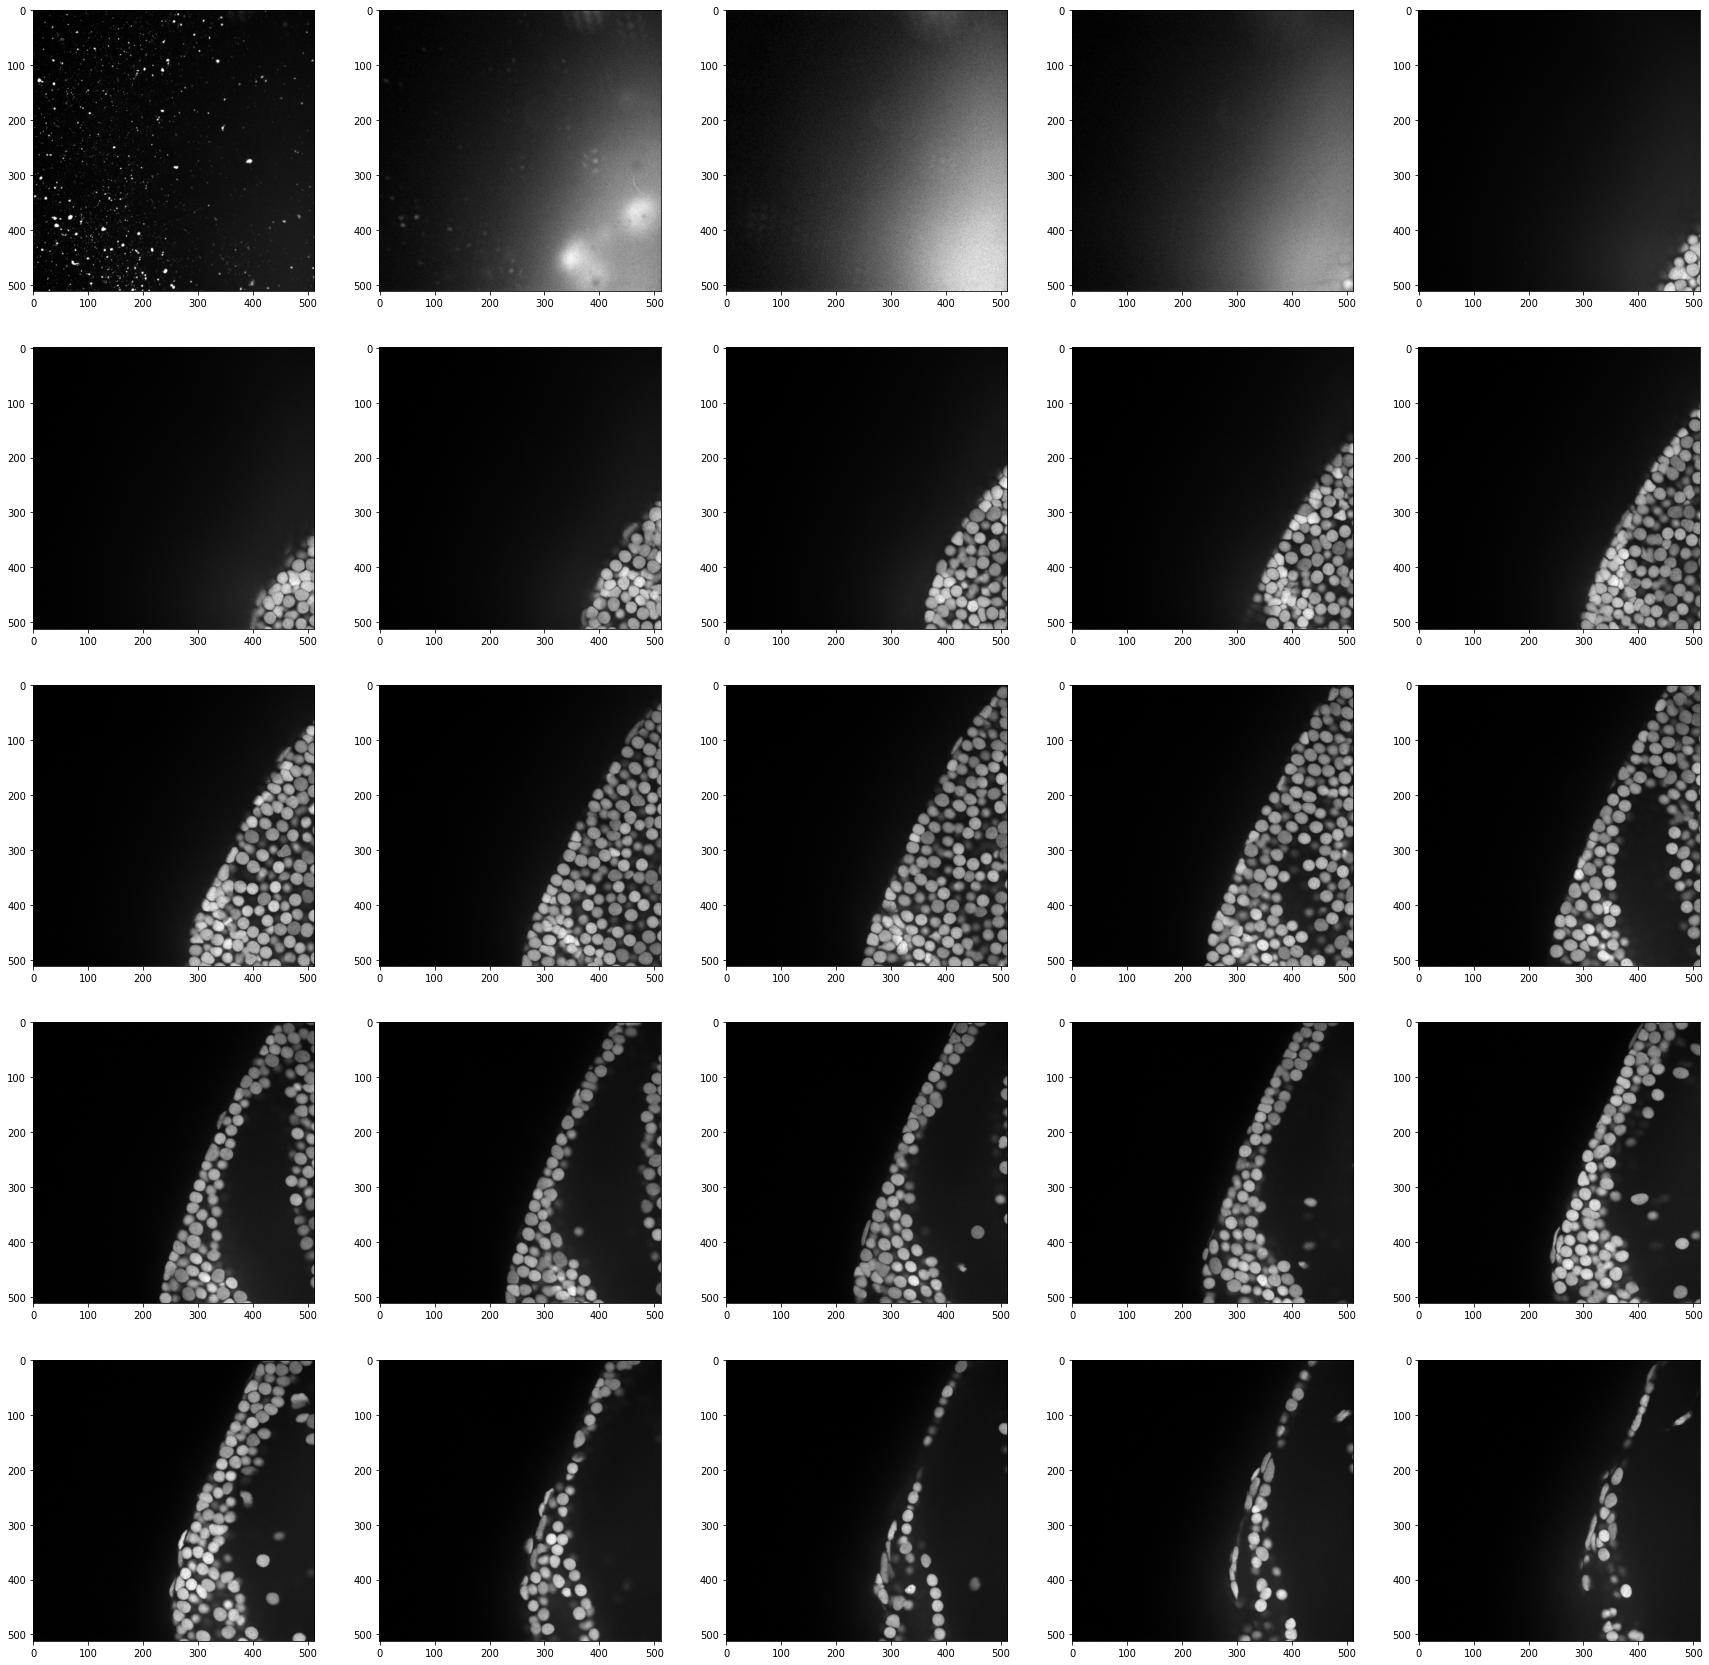

In [8]:
with h5py.File("/n/pfister_lab2/Lab/zudilin/data/NucExM/NucExM-Release/downsampled/image5_ds_4x.h5") as h5:
    images = h5.get("main")
    
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(30,30))
    plt.set_cmap('gray')

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i*10,:,:])
